# Loading dependencies

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn import __version__ as sklearnver
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

import xgboost as xgb

print(f'sklearn version: {sklearnver}')
print(f'xgboost version: {xgb.__version__}')

sklearn version: 1.6.1
xgboost version: 3.1.2


# simulating Field keys and normalized values in which the input format will be converted into

In [2]:
target_column = 'dropoutFlag'

fieldKeys = [
  'age',
  'attendancePercentage',
  'lateSubmissionCount',
  'cgpa',
  'previousYearPerformance',
  'mathScore',
  'englishScore',
  'scienceScore',
  'projectScore',
  'totalMarks',
  'feesPaid',
  'libraryDues',
  'sportsScore',
  'behaviorScore',
  'scholarshipEligibility',
  'specialNeedsFlag'
]

model_columns = fieldKeys + [target_column]

model_columns

['age',
 'attendancePercentage',
 'lateSubmissionCount',
 'cgpa',
 'previousYearPerformance',
 'mathScore',
 'englishScore',
 'scienceScore',
 'projectScore',
 'totalMarks',
 'feesPaid',
 'libraryDues',
 'sportsScore',
 'behaviorScore',
 'scholarshipEligibility',
 'specialNeedsFlag',
 'dropoutFlag']

# Loading data

In [3]:
data = pd.read_csv('../data/processed-real-data.csv').drop('notEnrolled', axis=1)
data.columns

Index(['studyMode', 'previousEducation', 'displacedStatus', 'specialNeeds',
       'gender', 'scholarShipStatus', 'ageAtEnrollment', 'international',
       'dropoutStatus', 'parentEducation', 'parentEmployentStatus', 'feesPaid',
       'totalCreditsEnrolled', 'totalCreditsApproved', 'cgpa'],
      dtype='object')

In [4]:
data.head()

,studyMode,previousEducation,displacedStatus,specialNeeds,gender,scholarShipStatus,ageAtEnrollment,international,dropoutStatus,parentEducation,parentEmployentStatus,feesPaid,totalCreditsEnrolled,totalCreditsApproved,cgpa
0,1,1,1,0,1,0,20,0,1,13,0,1,0.0,0.00,0.26
1,1,1,1,0,1,0,19,0,0,3,1,0,12.0,12.00,6.92
2,1,1,1,0,1,0,19,0,1,27,1,0,12.0,0.27,0.82
3,1,1,1,0,0,0,20,0,0,27,0,1,12.0,11.00,6.48
4,0,1,0,0,0,0,45,0,0,28,1,1,12.0,11.00,6.35


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4397 entries, 0 to 4396
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   studyMode              4397 non-null   int64  
 1   previousEducation      4397 non-null   int64  
 2   displacedStatus        4397 non-null   int64  
 3   specialNeeds           4397 non-null   int64  
 4   gender                 4397 non-null   int64  
 5   scholarShipStatus      4397 non-null   int64  
 6   ageAtEnrollment        4397 non-null   int64  
 7   international          4397 non-null   int64  
 8   dropoutStatus          4397 non-null   int64  
 9   parentEducation        4397 non-null   int64  
 10  parentEmployentStatus  4397 non-null   int64  
 11  feesPaid               4397 non-null   int64  
 12  totalCreditsEnrolled   4397 non-null   float64
 13  totalCreditsApproved   4397 non-null   float64
 14  cgpa                   4397 non-null   float64
dtypes: f

In [6]:
target = 'dropoutStatus'
continous_features = ['ageAtEnrollment', 'totalCreditsEnrolled', 'totalCreditsApproved', 'cgpa']
categorical_features = data.drop(continous_features + [target], axis=1).columns.to_list()

len(continous_features), len(categorical_features)

(4, 10)

# EDA

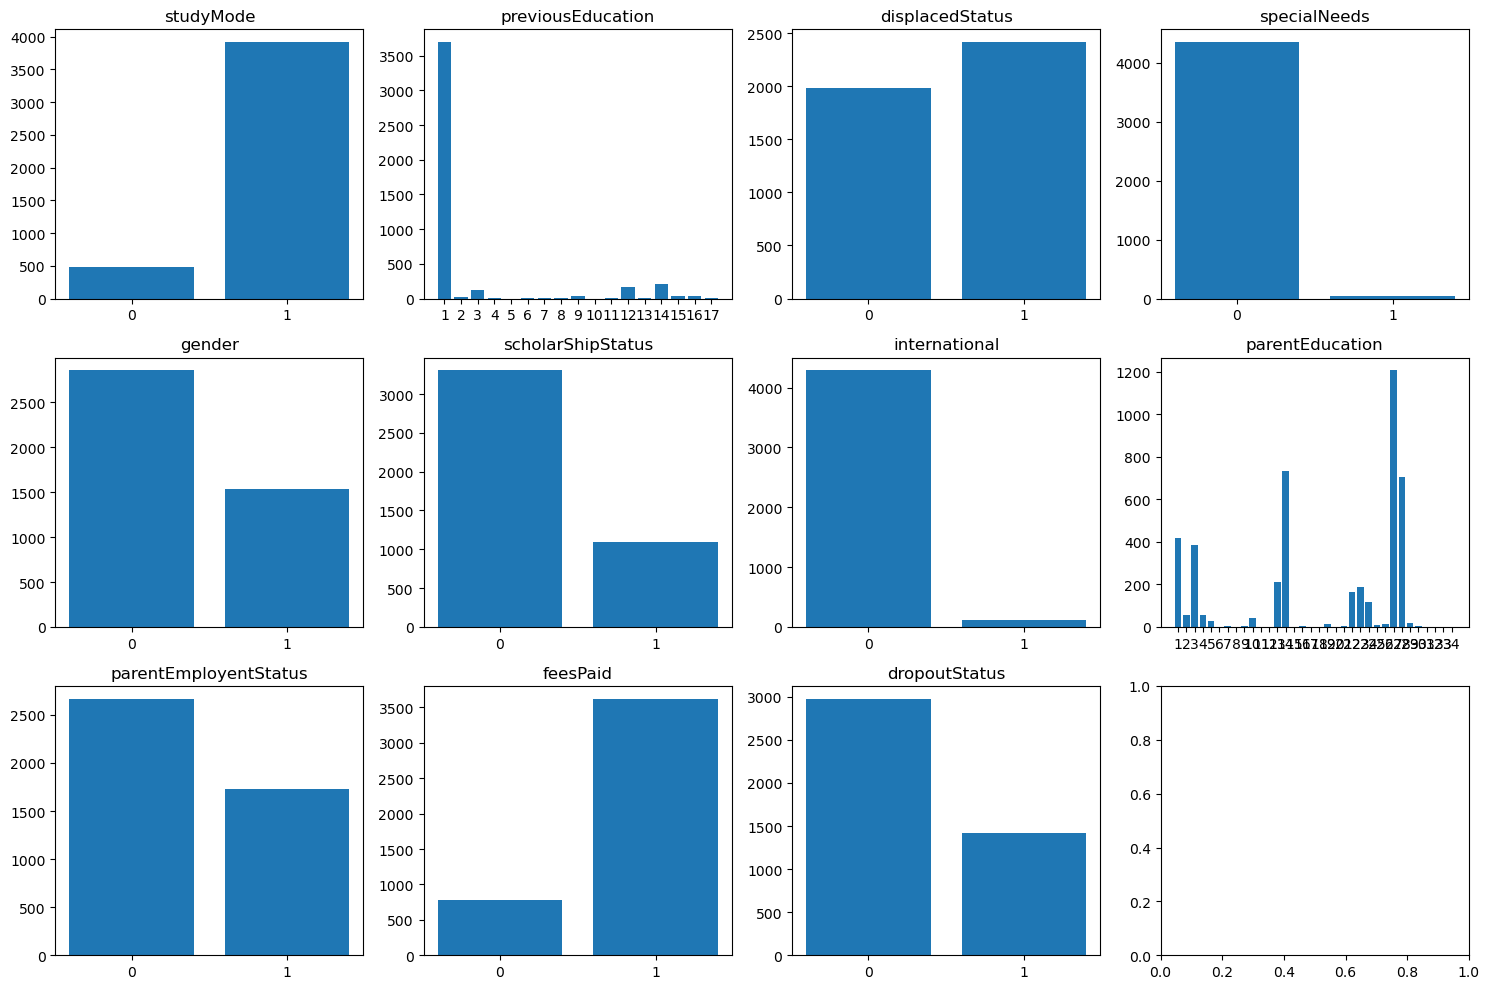

In [7]:
def show_dist(df, features):
  fig, axes = plt.subplots(3,4, figsize=(15,10))
  axes = axes.flatten()
  for ax, feature in zip(axes, features):
    value = df[feature].value_counts().reset_index()
    ax.bar(value[feature], value['count'])
    ax.set_title(feature)
    ax.set_xticks(value[feature].round())
  
  plt.tight_layout()
  plt.show()

show_dist(data, categorical_features + [target])

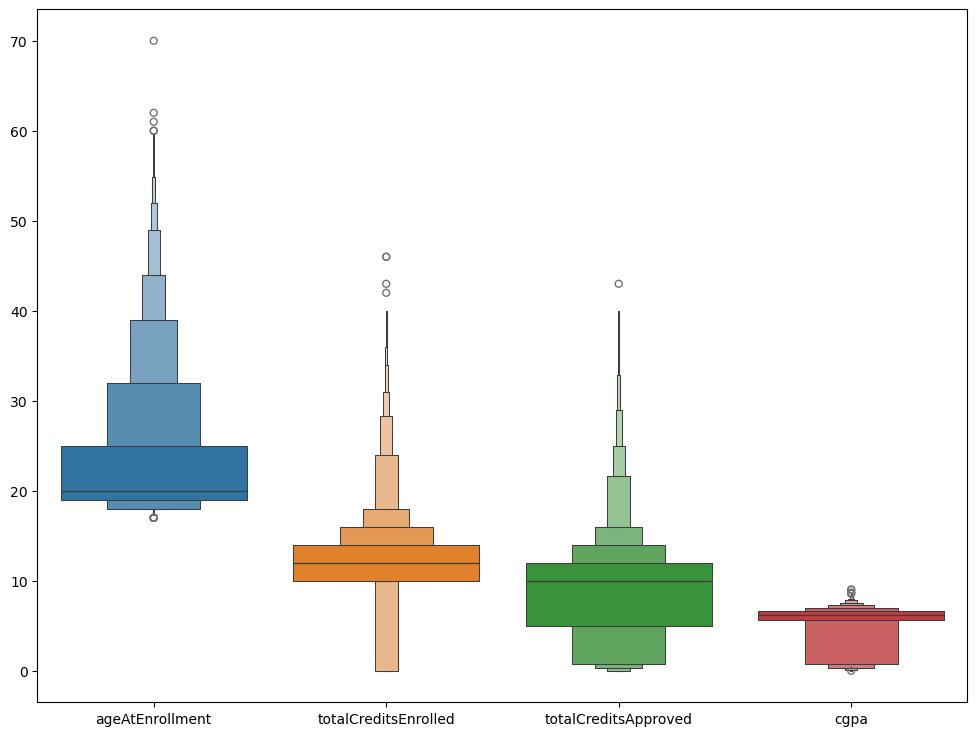

In [8]:
plt.figure(figsize=(12,9))
sns.boxenplot(data[continous_features])
plt.show()

# Preprocessing

In [9]:
minority = data[data['dropoutStatus'] == 1]
majority = data[data['dropoutStatus'] == 0]

upsampled_data = resample(
  minority,
  replace=True,
  n_samples=len(majority),
  random_state=42
)

balanced_data = pd.concat([majority, upsampled_data])
balanced_data.shape

(5952, 15)

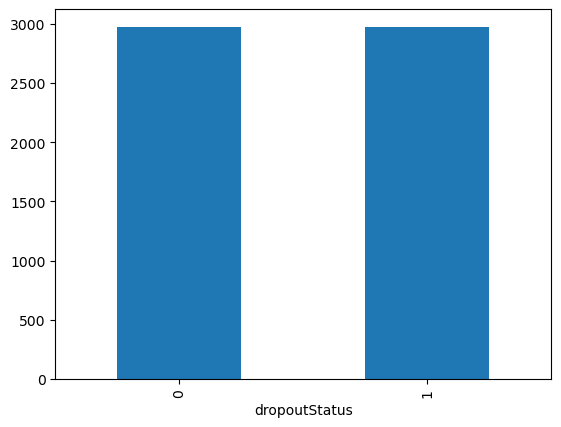

In [10]:
balanced_data['dropoutStatus'].value_counts().plot(kind='bar')
plt.show()

In [11]:
X, y = balanced_data.drop(target, axis=1), balanced_data[target]

sc = StandardScaler()
X_scaled = sc.fit_transform(X[continous_features])
X[sc.get_feature_names_out()] = X_scaled

X.shape, y.shape, X_scaled.shape

((5952, 14), (5952,), (5952, 4))

In [12]:
X.head()

,studyMode,previousEducation,displacedStatus,specialNeeds,gender,scholarShipStatus,ageAtEnrollment,international,parentEducation,parentEmployentStatus,feesPaid,totalCreditsEnrolled,totalCreditsApproved,cgpa
1,1,1,1,0,1,0,-0.620374,0,3,1,0,-0.073589,0.646269,0.753153
3,1,1,1,0,0,0,-0.496744,0,27,0,1,-0.073589,0.480270,0.572934
4,0,1,0,0,0,0,2.594015,0,28,1,1,-0.073589,0.480270,0.519688
5,0,12,0,0,1,0,3.212166,0,27,0,0,-0.510280,0.314271,0.310797
6,1,1,1,0,0,1,-0.744005,0,28,0,1,0.581448,1.144267,0.757249


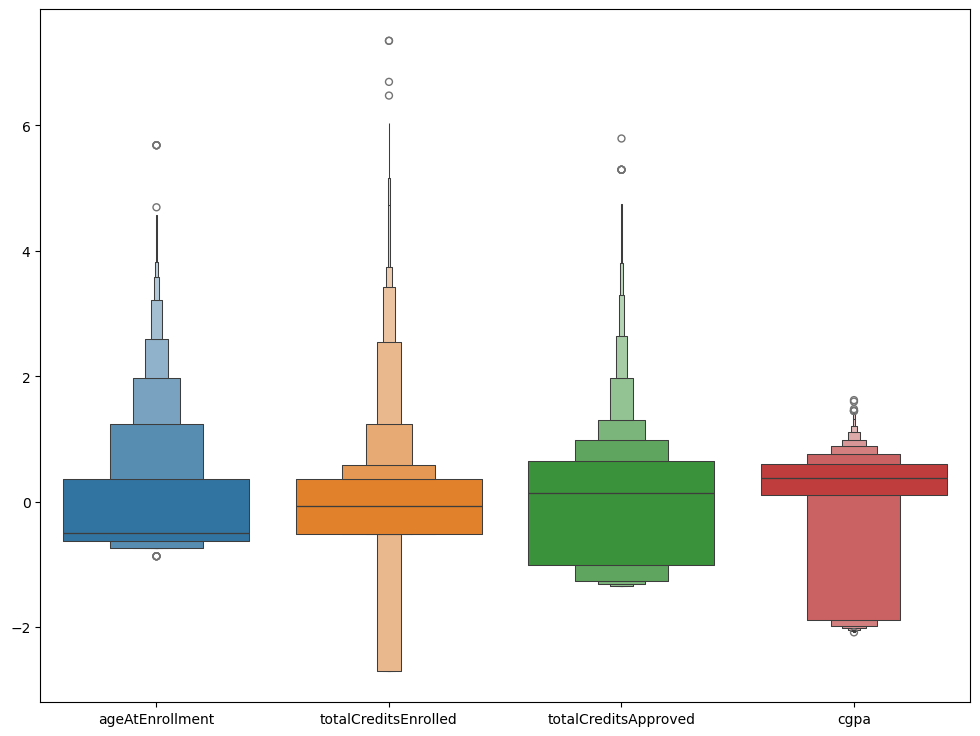

In [13]:
plt.figure(figsize=(12,9))
sns.boxenplot(X[continous_features])
plt.show()

# Model training

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

X_train.shape, X_test.shape

((4761, 14), (1191, 14))

In [15]:
X_train.columns

Index(['studyMode', 'previousEducation', 'displacedStatus', 'specialNeeds',
       'gender', 'scholarShipStatus', 'ageAtEnrollment', 'international',
       'parentEducation', 'parentEmployentStatus', 'feesPaid',
       'totalCreditsEnrolled', 'totalCreditsApproved', 'cgpa'],
      dtype='object')

In [16]:
train = xgb.DMatrix(data=X_train, label=y_train, nthread=-1)
test = xgb.DMatrix(data=X_test, label=y_test, nthread=-1)

In [17]:
model = xgb.XGBClassifier()

param_grid = {
  'n_estimators': [100,200,300],
  'max_depth': [6,10,15],
  'learning_rate': [0.001,0.01,0.1],
  'device': ['cuda'],
  'subsample': [1,0.5],
  'verbosity': [1]
}

grid = RandomizedSearchCV(model, param_grid, n_iter=30, scoring='f1', cv=5)

grid.fit(train.get_data(), train.get_label())

c:\Users\manpr\anaconda3\Lib\site-packages\xgboost\core.py:774: UserWarning: [22:34:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constrain...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=30,
                   param_distributions={'device': ['cuda'],
                                        'learning_rate': [0.001, 0.01, 0.1],
                                        'max_depth': [6, 10, 15],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [1, 0.5],
                                        'verbosity': [1]},
                   scoring='f1')

In [18]:
best_model = grid.best_estimator_

In [19]:
predictions = best_model.predict(X_test)

In [20]:
test_accuracy = accuracy_score(y_test, predictions)
print(f'Model accuracy on test data: {test_accuracy*100:0.2f}%')

Model accuracy on test data: 93.28%


In [21]:
class_report = classification_report(y_test, predictions)
print(class_report)

              precision    recall  f1-score   support

           0       0.96      0.91      0.93       615
           1       0.91      0.95      0.93       576

    accuracy                           0.93      1191
   macro avg       0.93      0.93      0.93      1191
weighted avg       0.93      0.93      0.93      1191



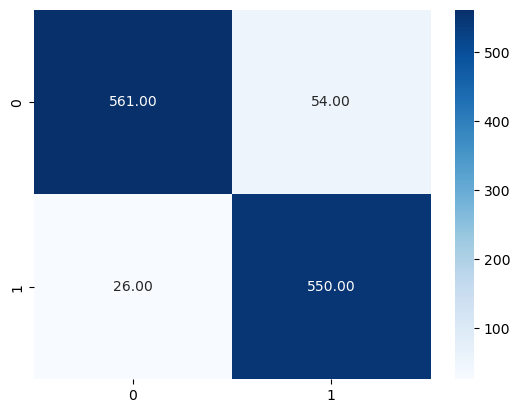

In [22]:
conf_mx = confusion_matrix(y_test, predictions)
sns.heatmap(conf_mx, annot=True, fmt='.2f', cmap='Blues')
plt.show()

In [23]:
pred_summary = pd.DataFrame({
  'real': y_test,
  'predictions': predictions
})

pred_summary

,real,predictions
3200,1,1
2629,1,1
2854,0,0
2501,1,1
1961,0,0
...,...,...
1321,0,0
2927,1,1
3274,0,0
18,0,0


In [25]:
pred_summary[pred_summary['predictions'] != pred_summary['real']].sum().sum()

np.int64(80)

# Saving model for use

In [27]:
number_of_models = len(os.listdir('../models'))
joblib.dump(best_model, f'../models/model_{number_of_models+1}.pth')

['../models/model_1.pth']